# MTrackJ

Steps:
- extract point data and manage the point data (execute in "read_imJ_pt" function)
- strain calcuation 
    - make a dataframe to find all combination for two points
    - calculate the length differences
    - calculate the strain
    - plot

In [1]:
import os
import shapefile as shp
from pyproj import Proj
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.tri as tri

import rasterio
import earthpy.spatial as es

import warnings
warnings.filterwarnings("ignore")

In [2]:
# import PVI txt
set1_fn = "../5_data_processing_v2_after_presentation/2_Set1/2_MTrackJ/set1_points.csv"
set2_fn ="../5_data_processing_v2_after_presentation/3_Set2/2_MTracksJ/set2_points.csv"
set3_fn = "../5_data_processing_v2_after_presentation/4_Set3/2_MTrackJ/set3_points.csv"


# Png
set1_png_fn = '../5_data_processing_v2_after_presentation/2_Set1/1_image_pair/extract2.png'
set2_png_fn ="../5_data_processing_v2_after_presentation/3_Set2/1_image_pair/extract3.png"
set3_png_fn = "../5_data_processing_v2_after_presentation/4_Set3/1_image_pair/extract4.png"

In [3]:
def read_imJ_pt (csv_fn):
    # read point data extracted from ImageJ
    pt_df = pd.read_csv(csv_fn, sep='\t', delimiter=',')
    
    # selected the useful columns
    pt_df = pt_df.iloc[:, :8]
    
    # create a df for PID 1 and 2 in one row
    PID_1 = pt_df.loc[pt_df['PID'].isin([1])]
    PID_2 = pt_df.loc[pt_df['PID'].isin([2])]

    # rename column
    PID_1 = PID_1.rename(columns = {'Nr': 'Nr_1', 'TID':'TID_1', 'PID':'PID_1','x [0]':'x_1',
                               'y [0]':'y_1', 't [sec]':'t_1', 'I [val]':'I_1',
                               'Len [0]':'Len_1'})
    
    
    PID_2 = PID_2.rename(columns = {'Nr': 'Nr_2', 'TID':'TID_2', 'PID':'PID_2','x [0]':'x_2',
                               'y [0]':'y_2', 't [sec]':'t_2', 'I [val]':'I_2',
                               'Len [0]':'Len_2'})
    
    # combine two table in one
    combine_df = pd.DataFrame()
    combine_df = PID_1.merge(PID_2, left_on = "TID_1",
                             right_on = 'TID_2')
    
    return combine_df
    

In [4]:
def img_extent(png_fn, pixel_value, know_dis_value):
    # function for setting image extent
    # from pixels to knowing distance
    # csv is in know distance, but image in pixel 
    
    # read image
    png = plt.imread(png_fn)
    
    # convert distance to match with pixels in png
    ratio = pixel_value/know_dis_value
    
    png_extent = [0, png.shape[1]/ratio,
                  png.shape[0]/ratio, 0]  #x&y is different in image
    
    return png_extent
    

In [5]:
def vector_plt(imJ_results, png_fn, png_extent):
    
    fig = plt.figure(figsize=(15, 7))
    ax = fig.add_subplot(1,1,1)
    png = plt.imread(png_fn)
    ax.imshow(png, extent = png_extent)
    
    
    thin = 1
    scale = 15 # scale = 0.05 --> U = 50
    q = ax.quiver(imJ_results['x_1'].values[1::thin], 
                  imJ_results['y_1'].values[1::thin],
                  imJ_results['x_1'].values[1::thin], 
                  imJ_results['y_1'].values[1::thin]*-1,
                  color = 'r',
                  scale = scale, 
                  scale_units = 'xy', alpha = 0.8)




    # plot scale for quivers
    plt.quiverkey(q, X = 0.9, Y = 0.9, U = 150, label = '1.5 m',
                 labelpos = "N", labelsep = 0.06, labelcolor = 'k',
                 fontproperties = {'size':12, 'weight':'bold'},
                 angle = 0)
    
    ####### add strain on the vector plot
#     sca = ax.scatter(x=strain_df['x_match_1'],
#            y=strain_df['y_match_1'],
#             c = strain_df['strains'], cmap='seismic',
#                  s=50,
#                  vmin = np.percentile(strain_df['strains'].values, 2), 
#                  vmax = np.percentile(strain_df['strains'].values, 98),
#                  alpha=0.8)


#     cbar = plt.colorbar(sca, ax = ax)
    ##### end
    

    plt.axis("off")
    
    plt.show()

    
    return fig
    

In [6]:
def interpolation (png_fn, imJ_results):
    png = plt.imread(png_fn)
    
    xi = np.linspace(0, png.shape[1], png.shape[1]) # start, stop, num of samples
    yi = np.linspace(0, png.shape[0], png.shape[0] )
    
    # match the ratio of the pixel and know-distance (pixel/know_dis)
    xi = xi/12
    yi = yi/12
    
    # take the coordinate to create grid
    triang = tri.Triangulation(imJ_results['x_1'].values,
                               imJ_results['y_1'].values)
    
    # meshgrid
    Xi, Yi = np.meshgrid(xi, yi)
    interp_disp = tri.CubicTriInterpolator(triang, imJ_results['Len_2'] )
    zi_disp = interp_disp(Xi, Yi)
    
    return xi, yi, zi_disp

In [7]:
def displacement_plt(imJ_results, png_fn, xi, yi, zi_disp, png_extent):

    
    ######################
    fig = plt.figure(figsize=(15, 7))
    ax = fig.add_subplot(1,1,1)
    png = plt.imread(png_fn)
    ax.imshow(png, extent = png_extent)
    
    cont = ax.contourf(xi, yi, zi_disp, levels = 30, 
                       cmap = 'jet', 
                       vmin = np.percentile(imJ_results['Len_2'].values, 2),
                       vmax = np.percentile(imJ_results['Len_2'].values, 98),
                       alpha = 0.4)
    
    
#     ### vector part ###
#     thin = 1
#     scale = 20 # scale = 0.05 --> U = 50
#     q = ax.quiver(imJ_results['x_1'].values[1::thin], 
#                   imJ_results['y_1'].values[1::thin],
#                   imJ_results['I_1'].values[1::thin], 
#                   imJ_results['I_2'].values[1::thin]*-1,
#                   color = 'r',
#                   scale = scale, 
#                   scale_units = 'xy', alpha = 0.5)




#     # plot scale for quivers
#     plt.quiverkey(q, X = 0.9, Y = 0.9, U = 200, label = '2 m',
#                  labelpos = "N", labelsep = 0.06, labelcolor = 'k',
#                  fontproperties = {'size':12, 'weight':'bold'},
#                  angle = 0)
    
    ### vector part end ####
    


    ax = plt.gca()
    ax.ticklabel_format(style = 'plain')
    cb = fig.colorbar(cont, orientation = 'vertical', fraction = 0.03)
    cb.set_label('Displacement [m]')
    plt.yticks(rotation = 90, verticalalignment = 'center')
    
    plt.axis("off")
    plt.show()
    
    return fig

### Strain

In [9]:
# strain calculation for all points in df
def distance(dataframe): 
    
    dataframe["distance1_2"] = np.sqrt((dataframe["x_match_1"] -dataframe["x_match_2"])**2 + (dataframe["y_match_1"] -dataframe["y_match_2"])**2)
    
    return dataframe.round(2)

def strain (dataframe):
    dataframe["strains"]= dataframe["len_diff"]/dataframe["distance1_2"]
    
    return dataframe.round(2)

def iter_row(imJ_results):
   # from one point match all other point
    
    import itertools
    
    combination_list = []
    TID_com = list(itertools.combinations(imJ_results["TID_1"], 2))
    combination_list.append(TID_com)
    len_com = list(itertools.combinations(imJ_results["Len_2"].round(2), 2))
    combination_list.append(len_com)
    x_com = list(itertools.combinations(imJ_results["x_1"].round(2), 2))
    combination_list.append(x_com)
    y_com = list(itertools.combinations(imJ_results["y_1"].round(2), 2))
    combination_list.append(y_com)
    
    # put the list in the new df
    df = pd.DataFrame(combination_list).transpose().round(2)
    
    # seperate vectors and rename the df columns
    
    df[["TID_match_1", "TID_match_2"]] = pd.DataFrame(df[0].values.tolist(), index = df.index )
    df[["Len_match_1", "Len_match_2"]] = pd.DataFrame(df[1].values.tolist(), index = df.index)
    df[["x_match_1", "x_match_2"]] = pd.DataFrame(df[2].values.tolist(), index = df.index)
    df[["y_match_1", "y_match_2"]] = pd.DataFrame(df[3].values.tolist(), index = df.index)
    
    # select useful columns
    df = df.iloc[:, 4:]
    
    # Strain 𝑒=Δ𝐿/𝐿0 calculation
    # calculate len difference
    df["len_diff"] = df["Len_match_1"] - df["Len_match_2"]
    
    # calculate distance for two new points and strain
    df = distance(df)
    df = strain(df)
    
    return df
   

In [10]:
# strain plot
def strain_plt (strain_df, png_fn, png_extent):
    fig = plt.figure(figsize=(15, 7))
    ax = fig.add_subplot(1,1,1)
    png = plt.imread(png_fn)
    ax.imshow(png, extent = png_extent)

    # sca = ax.scatter(x=df['x_coor_1'],
    #            y=df['y_coor_1'],
    #            s=df['strains']*1000, c = df['strains'], cmap='tab20b', 
    #                  vmin = np.percentile(df['strains'].values, 2), vmax = np.percentile(df['strains'].values, 98),
    #                  alpha=0.8)


    sca = ax.scatter(x=strain_df['x_match_1'],
               y=strain_df['y_match_1'],
                c = strain_df['strains'], cmap='seismic',
                     s=10,
                     vmin = np.percentile(strain_df['strains'].values, 2), 
                     vmax = np.percentile(strain_df['strains'].values, 98),
                     alpha=0.8)


#     cbar = plt.colorbar(sca, ax = ax)
#     cbar.set_label("Strain")

    ax = plt.gca()
    ax.ticklabel_format(style = 'plain')
    cb = fig.colorbar(sca, orientation = 'vertical', fraction = 0.03)
    cb.set_label('Strain')
    plt.yticks(rotation = 90, verticalalignment = 'center')
    plt.grid()
    plt.axis("off")
    plt.show()
    #fig.savefig("../4_python/output/6_set3_strain_img.png")
    
    return fig

In [8]:
# Displacement histogram
def disp_hist_plt(imJ_results):
    
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(1,1,1)
    ax.hist(imJ_results["Len_2"], bins = 50, color= "#ee6363")
    ax.set_xlabel("Displacement (unit: meters)", fontsize = 12)
    ax.set_ylabel("Accumulation", fontsize = 12)
    plt.grid()
    
    plt.show()
    
    return fig

def strain_hist_plt(strain_df):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(1,1,1)
    ax.hist(strain_df["strains"], bins = 20, range=[-0.1, 0.1],color= "darkorange")
    ax.set_xlabel("Strain", fontsize = 12)
    ax.set_ylabel("Accumulation", fontsize = 12)
    plt.grid()
    plt.show()
    
    return fig

# Set 1 Dataset
## Data input

In [11]:
Mtrack_df = read_imJ_pt(set1_fn)

In [12]:
Mtrack_df.head()

Nr_1  TID_1  PID_1     x_1     y_1  t_1    I_1  Len_1  Nr_2  TID_2  PID_2  \
0     3      2      1  63.713  38.040    0   85.3    0.0     4      2      2   
1     5      3      1  60.269  38.431    0   96.5    0.0     6      3      2   
2     7      4      1  55.729  39.762    0  100.6    0.0     8      4      2   
3     9      5      1  78.506  36.631    0   51.1    0.0    10      5      2   
4    11      6      1  85.550  37.335    0   46.8    0.0    12      6      2   

      x_2     y_2  t_2    I_2  Len_2  
0  63.713  39.605    0  109.4  1.565  
1  60.347  39.605    0  113.2  1.177  
2  55.886  40.858    0   87.9  1.107  
3  78.506  38.118    0   67.9  1.487  
4  85.472  38.353    0   53.5  1.021

## Image extent (match between pixels and know-distance)

In [13]:
pixel = 472
know_dis = 37
img_ext = img_extent(set1_png_fn, pixel, know_dis)

## Vector plot

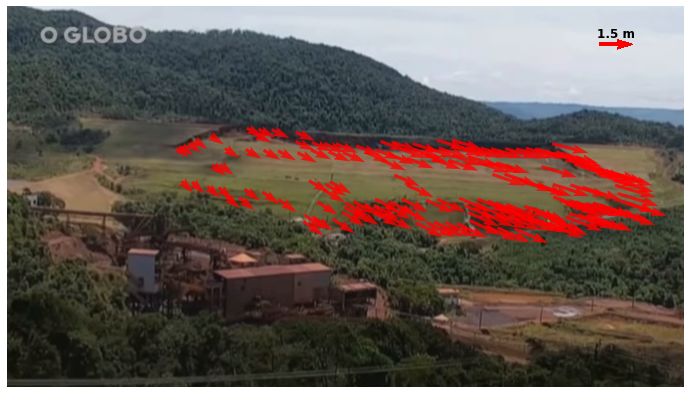

In [14]:
vect_plt = vector_plt(Mtrack_df, set1_png_fn, img_ext)
#vect_plt.savefig("../4_python/output_2_newdataset/1_set1_MTJ_vector2.png")


## Displacement interpolation plot

In [15]:
xi, yi, zi_disp = interpolation(set1_png_fn, Mtrack_df)

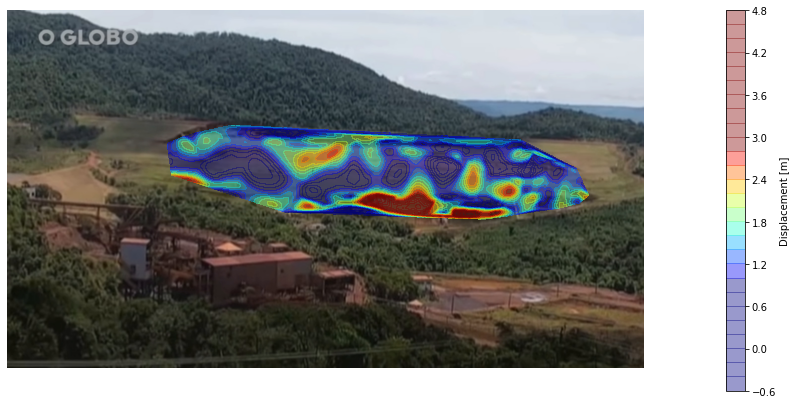

In [16]:
disp_plt = displacement_plt(Mtrack_df, set1_png_fn, xi, yi, zi_disp, img_ext )
#disp_plt.savefig("../4_python/output_2_newdataset/1_set1_MTJ_disp_v2.png")

## Strain

In [17]:
strain_df = iter_row(Mtrack_df)
strain_df.head()

TID_match_1  TID_match_2  Len_match_1  Len_match_2  x_match_1  x_match_2  \
0            2            3         1.56         1.18      63.71      60.27   
1            2            4         1.56         1.11      63.71      55.73   
2            2            5         1.56         1.49      63.71      78.51   
3            2            6         1.56         1.02      63.71      85.55   
4            2            7         1.56         1.33      63.71      85.55   

   y_match_1  y_match_2  len_diff  distance1_2  strains  
0      38.04      38.43      0.38         3.46     0.11  
1      38.04      39.76      0.45         8.16     0.06  
2      38.04      36.63      0.07        14.87     0.00  
3      38.04      37.34      0.54        21.85     0.02  
4      38.04      40.15      0.23        21.94     0.01

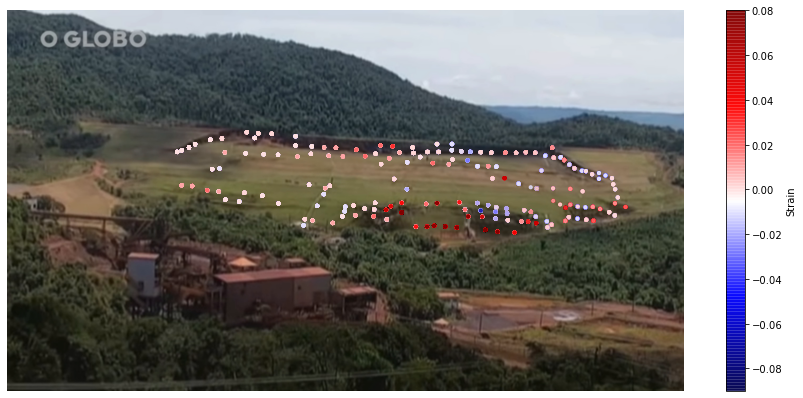

In [18]:
strain_plt(strain_df,set1_png_fn, img_ext).savefig("../4_python/output_2_newdataset/1_set1_MTJ_strain.png")

In [19]:
#strain_hist_plt(strain_df).savefig("../4_python/output_2_newdataset/1_set1_MTJ_strain_hist.png")

# Set 2 Dataset

In [20]:
Mtrack_df = read_imJ_pt(set2_fn)

In [21]:
Mtrack_df.head()

Nr_1  TID_1  PID_1     x_1     y_1  t_1   I_1  Len_1  Nr_2  TID_2  PID_2  \
0     1      1      1  67.949  36.460    0  48.6    0.0     2      1      2   
1     3      2      1  63.451  39.223    0  81.9    0.0     4      2      2   
2     5      3      1  71.658  37.644    0  40.3    0.0     6      3      2   
3     7      4      1  75.920  38.039    0  36.8    0.0     8      4      2   
4     9      5      1  59.347  39.775    0  87.5    0.0    10      5      2   

      x_2     y_2  t_2    I_2  Len_2  
0  68.028  38.591    0   61.3  2.132  
1  63.372  40.722    0  114.2  1.502  
2  71.737  39.696    0   98.8  2.053  
3  75.999  39.459    0   77.2  1.423  
4  59.426  40.880    0   95.9  1.108

## Image extent (match between pixels and know-distance)

In [22]:
pixel = 469
know_dis = 37
img_ext = img_extent(set2_png_fn, pixel, know_dis)

## Vector plot

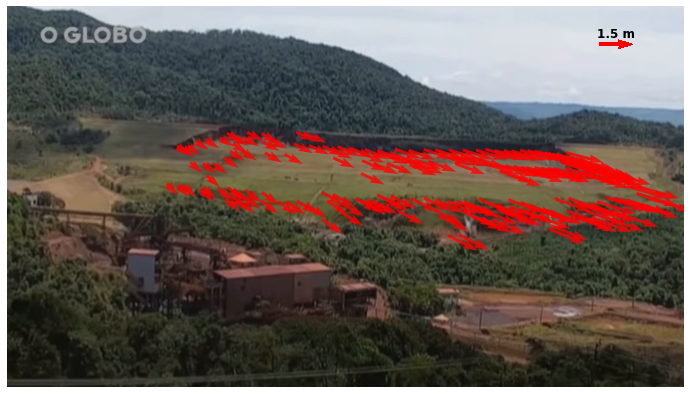

In [23]:
vect_plt = vector_plt(Mtrack_df, set2_png_fn, img_ext)
#vect_plt.savefig("../4_python/output_2_newdataset/2_set2_MTJ_vector2.png")

## Displacement interpolation plot

In [24]:
xi, yi, zi_disp = interpolation(set2_png_fn, Mtrack_df)

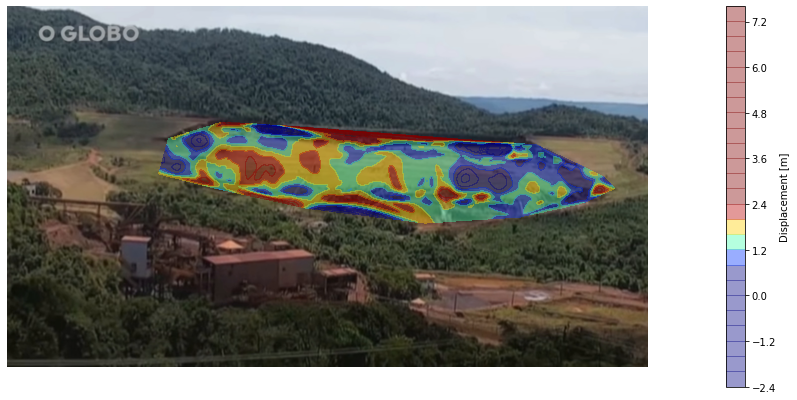

In [25]:
disp_plt = displacement_plt(Mtrack_df, set2_png_fn,xi, yi, zi_disp, img_ext)
#disp_plt.savefig("../4_python/output_2_newdataset/2_set2_MTJ_disp_v2.png")

## Strain

In [26]:
strain_df = iter_row(Mtrack_df)
strain_df.head()

TID_match_1  TID_match_2  Len_match_1  Len_match_2  x_match_1  x_match_2  \
0            1            2         2.13         1.50      67.95      63.45   
1            1            3         2.13         2.05      67.95      71.66   
2            1            4         2.13         1.42      67.95      75.92   
3            1            5         2.13         1.11      67.95      59.35   
4            1            6         2.13         1.59      67.95      56.35   

   y_match_1  y_match_2  len_diff  distance1_2  strains  
0      36.46      39.22      0.63         5.28     0.12  
1      36.46      37.64      0.08         3.89     0.02  
2      36.46      38.04      0.71         8.13     0.09  
3      36.46      39.78      1.02         9.22     0.11  
4      36.46      40.25      0.54        12.20     0.04

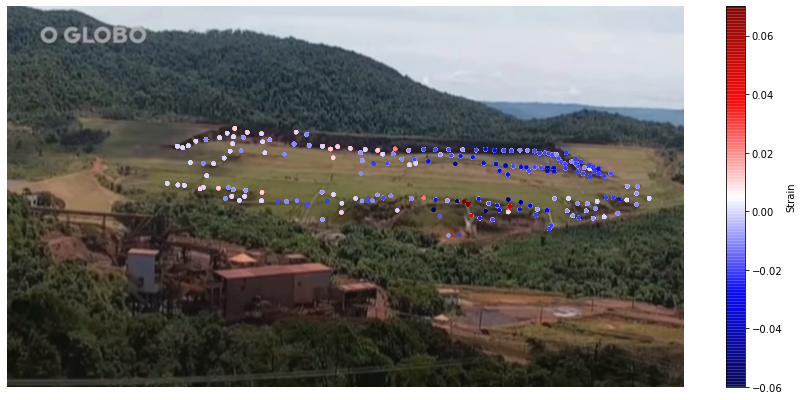

In [27]:
strain_plt(strain_df,set2_png_fn, img_ext).savefig("../4_python/output_2_newdataset/2_set2_MTJ_strain.png")

In [28]:
#strain_hist_plt(strain_df).savefig("../4_python/output_2_newdataset/2_set2_MTJ_strain_hist.png")

# Set 3 Dataset

In [29]:
Mtrack_df = read_imJ_pt(set3_fn)

In [30]:
Mtrack_df.head()

Nr_1  TID_1  PID_1     x_1     y_1  t_1    I_1  Len_1  Nr_2  TID_2  PID_2  \
0     1      1      1  66.154  38.361    0   54.6    0.0     2      1      2   
1     3      2      1  60.987  40.319    0  106.7    0.0     4      2      2   
2     5      3      1  73.983  38.675    0   48.9    0.0     6      3      2   
3     7      4      1  70.538  38.988    0   67.8    0.0     8      4      2   
4     9      5      1  55.194  41.493    0   86.1    0.0    10      5      2   

      x_2     y_2  t_2    I_2  Len_2  
0  66.232  39.927    0   69.2  1.568  
1  60.987  41.415    0  113.7  1.096  
2  74.061  40.240    0   64.9  1.568  
3  70.616  40.240    0   88.9  1.255  
4  55.350  42.980    0   88.7  1.496

## Image extent (match between pixels and know-distance)

In [31]:
pixel = 472
know_dis = 37
img_ext = img_extent(set2_png_fn, pixel, know_dis)

## Vector plot

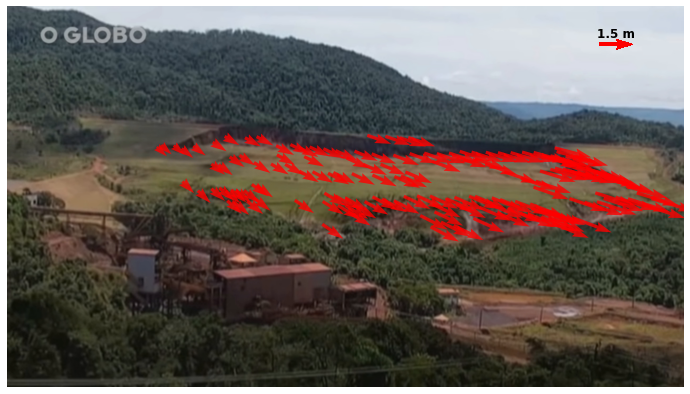

In [32]:
vect_plt = vector_plt(Mtrack_df, set3_png_fn, img_ext)
#vect_plt.savefig("../4_python/output_2_newdataset/3_set3_MTJ_vector2.png")

## Displacement interpolation plot

In [33]:
xi, yi, zi_disp = interpolation(set3_png_fn, Mtrack_df)

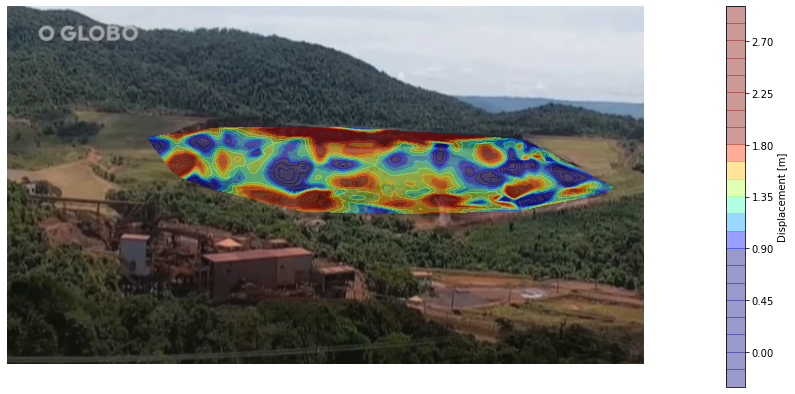

In [34]:
disp_plt = displacement_plt(Mtrack_df, set3_png_fn,xi, yi, zi_disp, img_ext)
#disp_plt.savefig("../4_python/output_2_newdataset/3_set3_MTJ_disp_v2.png")

## Strain

In [35]:
strain_df = iter_row(Mtrack_df)
strain_df.head()

TID_match_1  TID_match_2  Len_match_1  Len_match_2  x_match_1  x_match_2  \
0            1            2         1.57         1.10      66.15      60.99   
1            1            3         1.57         1.57      66.15      73.98   
2            1            4         1.57         1.25      66.15      70.54   
3            1            5         1.57         1.50      66.15      55.19   
4            1            6         1.57         1.35      66.15      49.40   

   y_match_1  y_match_2  len_diff  distance1_2  strains  
0      38.36      40.32      0.47         5.52     0.09  
1      38.36      38.67      0.00         7.84     0.00  
2      38.36      38.99      0.32         4.43     0.07  
3      38.36      41.49      0.07        11.40     0.01  
4      38.36      41.34      0.22        17.01     0.01

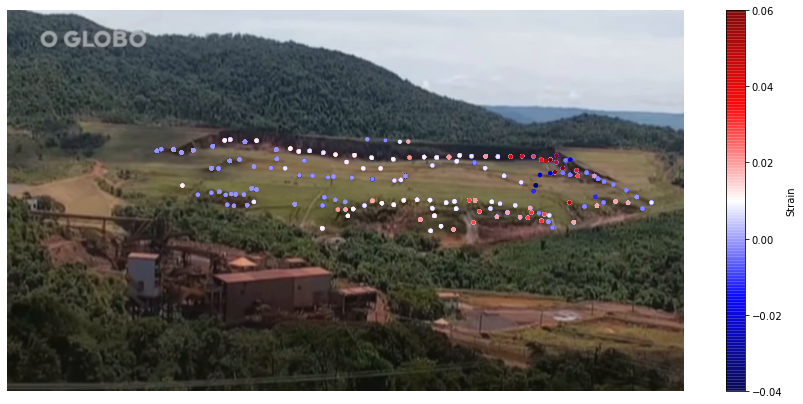

In [36]:
strain_plt(strain_df,set3_png_fn, img_ext).savefig("../4_python/output_2_newdataset/3_set3_MTJ_strain.png")

In [37]:
#strain_hist_plt(strain_df).savefig("../4_python/output_2_newdataset/3_set3_MTJ_strain_hist.png")